### imports

In [1]:
import polars as pl
from polars import col as c
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from catboost import CatBoostRegressor
import shap
import pandas as pd
from numpy.typing import ArrayLike, NDArray
import holidays

/Users/hq-n2y0j7g2k4/Documents/ml-engineer-greenscreens/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### constants

In [2]:
DATA_DIR = "dataset"
US_HOLIDAYS = holidays.US()  # this is a dict-like object

### functions

In [3]:
def mape_f(y_true: ArrayLike, y_pred: ArrayLike) -> np.floating:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    metric = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return round(metric, 2)

### data

In [4]:
path = os.path.join("../", DATA_DIR, "train_df.parquet")
train_df = pl.read_parquet(path)

path = os.path.join("../", DATA_DIR, "eval_df.parquet")
eval_df = pl.read_parquet(path)

path = os.path.join("../", DATA_DIR, "validation.parquet")
validation = pl.read_parquet(path)

path = os.path.join("../", DATA_DIR, "test.parquet")
test = pl.read_parquet(path)

In [5]:
train_df.sample()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,month,weekday,week,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile,kma_pair,kma_track,count_deliveries_from_kma,count_deliveries_to_kma,count_deliveries_kma_pair,kma_transport_median,kma_track_miles_median,kma_track_rate_median,rolling_rate_diff,shifted_week_rate
f64,f64,str,f64,datetime[μs],str,str,i8,i8,i8,i32,date,i64,i64,f64,f64,str,str,u32,u32,u32,f64,f64,f64,f64,f64
4.7135,5.130242,"""MKPFX""",13435.5,2022-03-23 13:42:00,"""VCEUE""","""DLGVW""",3,3,12,2022,2022-03-23,0,0,2.2714e6,79.472725,"""VCEUE_DLGVW""","""DLGVW_VCEUE""",45,6,4,4.7892,5.130242,4.7892,0.05105,4.64275


### model

In [6]:
def xy_split(
    data: pl.DataFrame,
    target: str = "rate",
) -> tuple[pd.DataFrame, pd.DataFrame]:
    X = data.drop(
        [
            "date",
            "pickup_date",
            # "hour",
            # "kma_pair",
            # "origin_kma",
            # "destination_kma",
            target,
        ]
    ).to_pandas()
    y = data[target].to_pandas()
    return X, y

In [7]:
CATEGORICAL_FEATURES = [
    "transport_type",
    "origin_kma",
    "destination_kma",
    "kma_pair",
    "kma_track",
    "month",
    "weekday",
    "week",
    "year",
    "is_holiday",
    "is_holiday_next_week",
]

In [12]:
def fit_and_eval_catboost(
    train_df: pl.DataFrame,
    eval_df: pl.DataFrame,
    test_df: pl.DataFrame,
) -> CatBoostRegressor:

    X_train, y_train = xy_split(train_df)
    X_eval, y_eval = xy_split(eval_df)
    X_test, y_test = xy_split(test_df)

    model = CatBoostRegressor(
        random_seed=1984,
        cat_features=CATEGORICAL_FEATURES,
        eval_metric="MAPE",
        # loss_function="MAPE",
        depth=3,
        iterations=500,
        learning_rate=0.06,
        # thread_count=16,
        # used_ram_limit="128GB",
    )

    model.fit(
        X=X_train,
        y=y_train,
        early_stopping_rounds=50,
        verbose=True,
        eval_set=(
            X_eval,
            y_eval,
        ),
    )

    predicted = model.predict(X_test)
    predicted[predicted <= 0] = 0

    result_df = pd.DataFrame(
        {
            "preds": predicted,
            "fact": y_test,
        }
    )

    metric = mape_f(
        result_df.fact,
        result_df.preds,
    )
    print("CatBoost MAPE:", metric)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_train)
    shap.plots.beeswarm(shap_values, plot_size=(8, 5))
    plt.show()

    return model, result_df

0:	learn: 0.3812234	test: 0.3445348	best: 0.3445348 (0)	total: 79.4ms	remaining: 39.6s
1:	learn: 0.3642938	test: 0.3308289	best: 0.3308289 (1)	total: 144ms	remaining: 35.9s
2:	learn: 0.3480324	test: 0.3184110	best: 0.3184110 (2)	total: 220ms	remaining: 36.4s
3:	learn: 0.3328724	test: 0.3064944	best: 0.3064944 (3)	total: 294ms	remaining: 36.4s
4:	learn: 0.3189748	test: 0.2957084	best: 0.2957084 (4)	total: 357ms	remaining: 35.3s
5:	learn: 0.3054999	test: 0.2856395	best: 0.2856395 (5)	total: 403ms	remaining: 33.2s
6:	learn: 0.2927929	test: 0.2760425	best: 0.2760425 (6)	total: 466ms	remaining: 32.8s
7:	learn: 0.2806666	test: 0.2670232	best: 0.2670232 (7)	total: 532ms	remaining: 32.7s
8:	learn: 0.2695948	test: 0.2590870	best: 0.2590870 (8)	total: 587ms	remaining: 32s
9:	learn: 0.2597206	test: 0.2518173	best: 0.2518173 (9)	total: 633ms	remaining: 31s
10:	learn: 0.2490393	test: 0.2440261	best: 0.2440261 (10)	total: 677ms	remaining: 30.1s
11:	learn: 0.2396401	test: 0.2374079	best: 0.2374079 (1

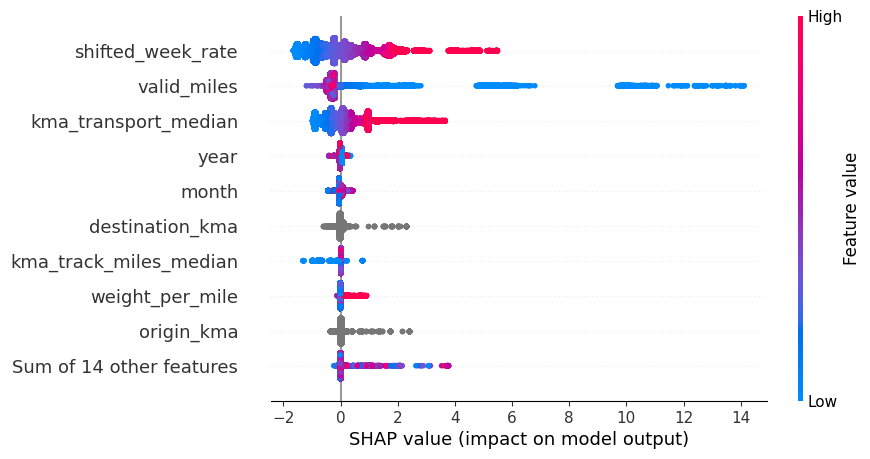

In [13]:
model, result_df = fit_and_eval_catboost(train_df, eval_df, validation)